In [1]:
# CSS style setting
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
colors = ['#064572', '#A8854F', '#7E98B2', '#663DB8', '#2D795E', '#57073E', '#AF550B', '#15042E', '#DD1E6A', '#CB9F07', '#44143B', '#0BAFA1']


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:123%; text-align:left">

<h3 align="left"><font color='#05041B'>💡🧠Overview :</font></h3>
    
    
* I will be implementing the CatBoost & Random Forest models on my database of 1800 leads sourced from my franchise consulting business, selecting 22 out of 150 attributes per lead.
* Despite imperfections in the data and its extraction from Hubspot, my goal is to optimize consultant efficiency and timely address opportunities with minimal impact.

* Notebook in spanish in: 


<p style="text-align:left;">
<img src="https://github.com/santiagocanepa/Optimizing-the-Management-of-1800-Own-Leads-in-HubSpot-Applying-XGB-CatBoost-and-Random-Forest/blob/main/imag/pngwing.com.png?raw=true" width="13.8%" height="30%">

<p style="text-align:left;">
    <img src="https://github.com/santiagocanepa/Optimizing-the-Management-of-1800-Own-Leads-in-HubSpot-Applying-XGB-CatBoost-and-Random-Forest/blob/main/imag/FQC_Logo_2@2x.png?raw=true" width="15%" height="30%">

### </p> <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📚Step 1: Importing Libraries and Modules

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import scikitplot as skplt
import scipy.stats as ss
import seaborn as sns
import os
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from plotly.subplots import make_subplots
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 



### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🔎 Step 2: Data Loading and Exploration</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* Data load (csv copy-paste de hubspot)
* Prelimiary analysis and transformation
* Cleaning and entry of empty fields
    

In [4]:
df = pd.read_excel("/kaggle/input/copy-leads-fqc-hubspot/copy_leads_FQC_hubspot.xlsx")

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Nombre                  5206 non-null   object 
 1   Apellido                1801 non-null   object 
 2   Pais                    1801 non-null   object 
 3   Zona Horaria            1801 non-null   object 
 4   Provincia               1801 non-null   object 
 5   Localidad               1801 non-null   object 
 6   Zona                    1801 non-null   object 
 7   Ciudad IP               1801 non-null   object 
 8   Estado actual del lead  1801 non-null   object 
 9   Fuente                  1801 non-null   object 
 10  Fuente Ultima           1702 non-null   object 
 11  Fuente Original         1801 non-null   object 
 12  Mensaje                 1801 non-null   object 
 13  Comentario              1801 non-null   object 
 14  formularios enviados    1801 non-null   

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* It is necessary to clean the data provided by HubSpot. First, we will remove the rows that contain initials and "vista previa" in the Nombre column.

* Additionally, we remove all NaN fields since the default empty field in HubSpot is "--".
    
* Furthermore, we modify the data types by converting the string values to lowercase and the numeric values to float.
    
* The "estado actual del lead" column will be our target column, and we will rename it as "v_target".

In [5]:
# df = df[(df['Nombre'].str.len() > 2) & (df['Nombre'] != 'Vista previa') ]

df = df.dropna(subset=['Nombre', 'Apellido'])
df = df.astype(str)
df = df.applymap(lambda s:s.lower().strip() if type(s) == str else s)

columnas_int = ['Visitas a la pagina', 'formularios enviados', 'Interacciones varias', 'Aperturas de correo']

for columna in columnas_int:
    df[columna] = df[columna].astype(float)  
    
# Elimino las columnas que no aportan al modelo ni al analisis.
df = df.drop(['Nombre','Apellido','correo','Mensaje','Comentario', 'numero ', 'Zona Horaria', 'Pais'], axis=1)

# Convertir todas las etiquetas de las columnas a minúsculas y eliminar los espacios en blanco al principio y al final
df.columns = df.columns.str.lower().str.strip()

# Renombrar la columna 'elead' a 'v_target'
df = df.rename(columns={'estado actual del lead': 'v_target'})



In [6]:
print('Categorical Variables')
df.describe(include='object').head(2)

Categorical Variables


,provincia,localidad,zona,ciudad ip,v_target,fuente,fuente ultima,fuente original,franquicia,inversion
count,1797,1797,1797,1797,1797,1797,1797,1797,1797,1797
unique,19,321,151,192,13,14,9,8,111,2


In [7]:
print("Numerical Variables")
df.describe().head(6)

Numerical Variables


,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo
count,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.824151,0.818587,0.956594,0.629382
std,0.744853,0.814970,2.025810,1.003104
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Now, I will try to classify, transform and reduce the predictor columns as much as possible.

In [8]:
cant_distintos = df.agg(pd.Series.nunique)
valores_unicos = {col: df[col].unique() for col in df.columns}
print("Number of different values in each column:")
print(cant_distintos)

Number of different values in each column:
provincia                19
localidad               321
zona                    151
ciudad ip               192
v_target                 13
fuente                   14
fuente ultima             9
fuente original           8
formularios enviados      8
visitas a la pagina       7
interacciones varias     15
aperturas de correo       8
franquicia              111
inversion                 2
dtype: int64


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📋 Step 3: Data Preprocessing | Variables predictoras & Variable Objetivo</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:114%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font> 📍 Lead Location </h3>

🖇️ Predictor Variables: "Province, City, Zone, IP City".
🖇️ Unified Predictor Variable: "zone"
Due to empty fields, the goal is to consolidate the information into 1 column called "zone".
Initially, the location variable of a prospect is relevant; however, the data is very dirty, and we will analyze its incorporation into the model and under what terms

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Definir las columnas categóricas
cat_columns = ['provincia', 'localidad', 'zona', 'ciudad ip']
# Calcular filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(cat_columns) / n_cols)
# Crear subplot
fig = make_subplots(rows=n_rows, cols=n_cols)
# Añadir gráficos de barras para cada variable categórica
for i, col in enumerate(cat_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    # Seleccionar los 6 valores más comunes
    top_values = df[col].value_counts().head(6)   
    fig.add_trace(go.Bar(
        x=top_values.index,
        y=top_values.values,
        name=col,
        text=top_values.values,
        textposition='auto',
        marker_color=colors[i % len(colors)]
    ), row=curr_row, col=curr_col)
# Actualizar layout
fig.update_layout(
    title_text='Distribution of the 6 most common categories for each variable',
    height=300 * n_rows,  
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Majority "--" (Empty Fields)

* I will attempt to select the first valid value (if any) from each row in the columns, defining the priorities from general to specific (Province to City), unifying the respective location columns into the new "zone" column, and leaving the entries without a value in the "no value" column.

In [10]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor
    return 'sin valor'
columnas = ['provincia', 'zona', 'ciudad ip', 'localidad']
df['zone'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)
top_20_zonas = df['zone'].value_counts().head(20)
fig_bar = px.bar(x=top_20_zonas.index, y=top_20_zonas, labels={'x': 'Zonas', 'y': 'Frecuencia'}, title='Top 20 zones more frequent in zone', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Unifying zone names when they contain terms relevant to frequently repeated provinces.


In [11]:
def unificar_nombre_zona(zone):
    if isinstance(zone , str):
        if any(substring in zone for substring in ['aires', 'buenos', 'caba', 'capital federal', 'la matanza', 'san justo', 'quilmes', 'san martin']):
            return 'buenos aires'
        elif 'santa ' in zone or 'rosario' in zone.lower():
            return 'santa fe'
        elif 'posadas' in zone.lower():
            return 'mendoza'
        else:
            return zone
    else:
        return zone
# Aplicando a cada valor de la columna 'zonas_unificadas'
df['zone'] = df['zone'].apply(unificar_nombre_zona)
# Eliminando el resto de columnas pertinentes a este area
df = df.drop(['provincia', 'zona', 'ciudad ip', 'localidad'], axis=1)
# Verificar el resultado
zf = df['zone'].value_counts().head(18)
fig_pie = px.pie(values=zf, names=zf.index, title="Zones Top 18", color_discrete_sequence=colors)
fig_pie.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Except for Buenos Aires, the remaining provinces do not have enough values to contribute to the model.
* Considering the relevance of other columns in the dataset, I prefer to avoid unnecessary biasing of the model, so I will divide the unified zone into 3 values.


In [12]:
top_3_zonas = df['zone'].value_counts().head(2).index
def agrupar_otras(valores, top3_zonas):
    if valores not in top3_zonas:
        return "zonas menos recurrentes"
    else:
        return valores
df['zone'] = df['zone'].apply(lambda x: agrupar_otras(x, top_3_zonas))
# Verificar el resultado
zf = df['zone'].value_counts()
fig_pie = px.pie(values=zf, names=zf.index, title='Final result in zone', color_discrete_sequence=colors)
fig_pie.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* I consider the geographic location variable "zona_unificada" concluded for now.
* Later on, I will verify its relationship with other columns, especially with the target column.

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:114%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🌐 Lead Source </h3>

* 🖇️ Predictor Variables: "original source", "last source", "source"
* 🖇️ Unified Predictor Variable: "source"
* Once again, we will unify the values, and in this case, reducing and even identifying and renaming the ""--"" will be much easier.

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Columnas categóricas
fue_columns = ['fuente', 'fuente original', 'fuente ultima']
# Filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(fue_columns) / n_cols)
# Crear subplot para cada variable categórica
fig = make_subplots(rows=n_rows, cols=n_cols)
for i, col in enumerate(fue_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    top_values = df[col].value_counts().head(6)
    fig.add_trace(go.Bar(
        x=top_values.index,
        y=top_values.values,
        name=col,
        text=top_values.values,
        textposition='auto',
        marker_color=colors[i % len(colors)]
    ), row=curr_row, col=curr_col)  
    fig.update_yaxes(title_text=col, row=curr_row, col=curr_col) #Asigno nombre de columna a titulo de etiqueta y
fig.update_layout(
    title_text='Distribution of the 6 most common categories for each Source variable',
    height=300 * n_rows,  # Reducir la altura aquí para eliminar el espacio en blanco
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* Selecting  **"Fuente"** as a priority to resolve disconnected sources, as "--" found replacements in the predictor variables  **"fuente original"** and **"fuente ultima"**

In [14]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor

columnas = ['fuente original', 'fuente ultima', 'fuente']
df['source'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)

# Verificar el resultado
print(df['source'].head())

0       fuentes sin conexión
2           búsqueda de pago
5          búsqueda orgánica
8     redes sociales de pago
11      fuentes sin conexión
Name: source, dtype: object


In [15]:
top_10fuentes = df['source'].value_counts().head(10)
import plotly.graph_objects as go
import plotly.express as px
fig_bar = px.bar(x=top_10fuentes.index, y=top_10fuentes, labels={'x': 'source', 'y': 'Frecuencia'}, title='Result in source', color_discrete_sequence=colors)
fig_bar.show()

In [16]:
# Elimino las columnas excedentes relacionadas a la fuente 
df = df.drop(['fuente original', 'fuente ultima', 'fuente'], axis=1)


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>💵Inversion (Ticket) </h3>  
    
* 🖇️Predictor Variable
* I decided to keep the "Investment" column despite containing empty values, as I can fill them using the "Franchise" column as a reference.



In [17]:
usd25mil = ['befruit', 'dulce hora', 'don antonio', 'central de pizzas y empanadas', 'big pizza']
usd60mil = ['pirka', 'guapaletas', 'don us company', 'quecrecen ar','le panem','vitalcer ', 'neo zoo', 'sanduba', 'el mundo del mueble', 'depi4ever', 'by papa', 'ferreterías h30', 'alma rural', 'all in express']
usd125mil = ['tienda de cafe', 'cafe martinez', 'cremolatti']
usd250mil = ['tostado', 'la birra bar', 'atalaya']


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Certainly, we keep the "Investment Amount" column as categorical. The current numeric values correspond to different levels of interaction, which allows us to observe a certain order in the classification by scale.

In [18]:

def asignar_inversion(franquicia):
    for f in franquicia.split(","): 
        f = f.strip() 
        if f in usd25mil:
            return 'low'
        elif f in usd60mil:
            return 'med'
        elif f in usd125mil:
            return 'high'
        elif f in usd250mil:
            return 'veryhigh'
    return 'Otro'
df['inversion'] = df['franquicia'].apply(asignar_inversion)
print(df.head())

                v_target  formularios enviados  visitas a la pagina  \
0   capital insuficiente                   0.0                  0.0   
2       no va a invertir                   1.0                  1.0   
5   capital insuficiente                   1.0                  1.0   
8           mala calidad                   1.0                  1.0   
11      no va a invertir                   0.0                  0.0   

    interacciones varias  aperturas de correo      franquicia inversion  \
0                    0.0                  0.0      guapaletas       med   
2                    1.0                  1.0    la birra bar  veryhigh   
5                    0.0                  0.0  don us company       med   
8                    0.0                  0.0      guapaletas       med   
11                   6.0                  2.0      alma rural       med   

                       zone                  source  
0              buenos aires    fuentes sin conexión  
2             

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🖇️Predictor Variable: Franchise</h3>  
    
* We have identified the top 25 franchises that appear most frequently.

* If you have any more questions, feel free to ask.


In [19]:
df['franquicia'] = df['franquicia'].str.split(',').str[0]
conteo = df['franquicia'].value_counts().head(35)
fig_bar = px.bar(x=conteo.index, y=conteo, labels={'x': 'Franchises', 'y': 'Number of leads received'}, title='Lead received x Franchises', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left"> 
    
* To simplify the categories, I tested various thresholds and defined the best possible relationship.

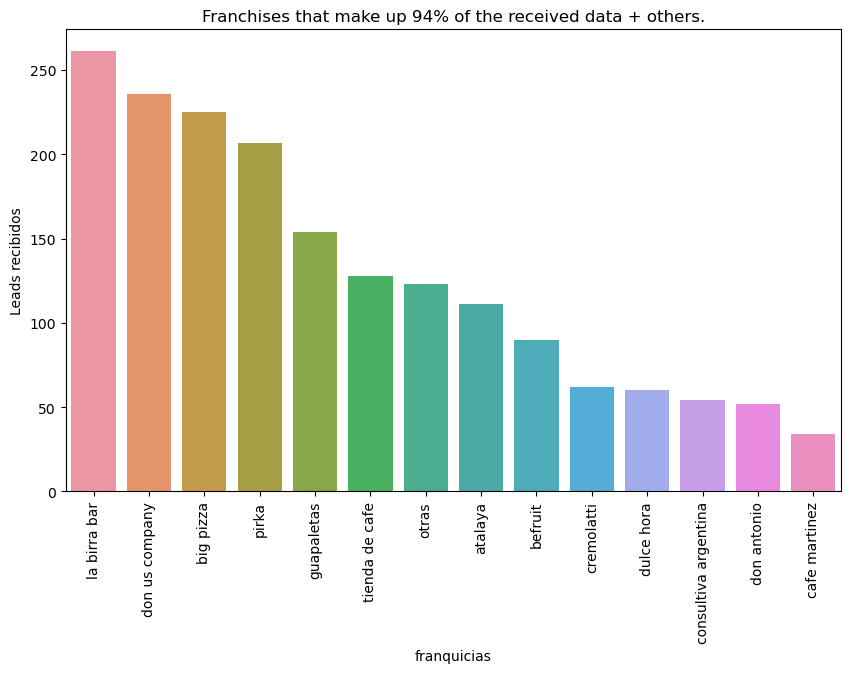

In [20]:
conteos = df['franquicia'].value_counts()
porcentaje_acumulado = conteos.cumsum() / conteos.sum()
umbral = porcentaje_acumulado[porcentaje_acumulado <= 0.94].shape[0]
# Encontrar las franquicias más comunes
franquicias_mas_comunes = conteos.index[:umbral]
# Reemplazar las franquicias que no están en las más comunes por 'Otras'
df['franquicia'] = df['franquicia'].where(df['franquicia'].isin(franquicias_mas_comunes), 'otras')
conteos = df['franquicia'].value_counts()
# Comprobar resultado 
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=conteos.index, y=conteos.values, ax=ax)
ax.set_title('Franchises that make up 94% of the received data + others.')
ax.set_xlabel('franquicias')
ax.set_ylabel('Leads recibidos')
plt.xticks(rotation=90)
plt.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left"> 
    
* 94% of the categories in the column are concentrated in these franchises, which will be used for the model, while the remaining ones will be grouped as 'others'.**

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🔢 Discreet / Continuous Variables</h3>  
   
* 🖇️ Predictor Variables:
* **Formularios enviados'**: Discrete variable representing the number of submitted forms.
* **'Visitas a la página'**: Discrete variable representing the number of website visits.
* **'Interacciones varias'**: Discrete variable representing the number of various interactions.
* **'Aperturas de correo'**: Discrete variable representing the number of email openings.

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* These columns will be the only ones incorporated into the model as numeric variables.
* They measure various interactions and can be very useful for models that categorize based on the natural order of their numeric columns. 
* First, I will ensure that there are no highly elevated relationships between the columns."

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Definir las columnas numéricas
num_columns = ['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']
# Calcular filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(num_columns) / n_cols)
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=num_columns)
# Histogramas para cada variable numérica
for i, col in enumerate(num_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    fig.add_trace(go.Histogram(
        x=df[col],
        name=col,
        marker_color='rgb(55, 83, 109)',
        nbinsx=50  # Ajustar el número de bins
    ), row=curr_row, col=curr_col)
    # Título y etiquetas de ejes
    fig.update_xaxes(title_text=col, row=curr_row, col=curr_col)
    fig.update_yaxes(title_text="Frec", row=curr_row, col=curr_col)
# Actualizar layout
fig.update_layout(
    title_text='Distribution of numerical variables',
    height=300 * n_rows,  # Reducir la altura aquí para eliminar el espacio en blanco
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:100%; text-align:left">
    
* We calculate the correlation matrix


<Axes: >

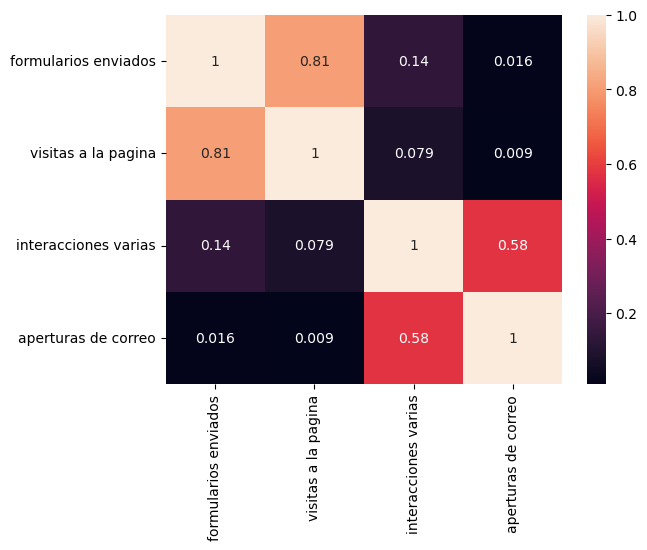

In [22]:
correlation_matrix = df[['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']].corr()
sns.heatmap(correlation_matrix, annot=True)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Visits to the page is a previous instance in the sales funnel and has a significant correlation with form shipments.


* Despite the similarities, they are different instances and I consider it relevant to differentiate them in the model.

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🧪 Variable Objective  (Current state of the lead : "v_target")</h3>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">

*  Due to the potential complexity of training a model with a large number of classes in the target column and the need for a substantial amount of data, the target column will be transformed into a binary classification. It will be grouped as follows:

First, we will count the number of unique values in the 'v_target' column.

In [23]:
eleadcount = df['v_target'].value_counts().head(20)
fig_bar = px.bar(x=eleadcount.index, y=eleadcount, labels={'x': 'v_target', 'y': 'Frecuencia'}, title='Variable Objective value distribution (v_target)', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">


*  Preparing the data for the model, I will define the classes in the **v_target** column as binary, separating them into  **"opportunity_lead"** and  **"unqualified_lead"**


In [24]:
def crear_clase_binaria (valor):  
    opportunity_lead = ['en seguimiento', 'calificado para la compra', 'clientes']
    unqualified_lead = ['capital insuficiente', 'mala calidad', 'imposible de contactar','no solicito información', 'aun sin respuesta', 'intentando contacto', 'no va a invertir', 'crowdfunding', 'formulario', 'remarketing']   
    if valor in opportunity_lead:
        return 'opportunity_lead'
    elif valor in  unqualified_lead:
        return 'unqualified_lead'
    else:
        return np.nan
    
    if valor in opportunity_lead:
        return 'opportunity_lead'
    elif valor in  unqualified_lead:
        return 'unqualified_lead'
    else:
        return np.nan
df['v_target'] = df['v_target'].apply(crear_clase_binaria)
df = df.dropna(subset=['v_target'])
print ('v_target in binary classes, to use in the model')
print (df['v_target'].value_counts())

v_target in binary classes, to use in the model
unqualified_lead    1577
opportunity_lead     198
Name: v_target, dtype: int64


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">

* The difference between the values of each class is significant, which is inherent to the business and the type of sales, and it can pose a challenge in the prediction model. 
* To address this, I will use the SMOTE technique for oversampling the minority class to mitigate class imbalance.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🔬 Step 4 Data Definition</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:113%; text-align:left">

* Relationship between **Predictor Variables** y **Variable Target**

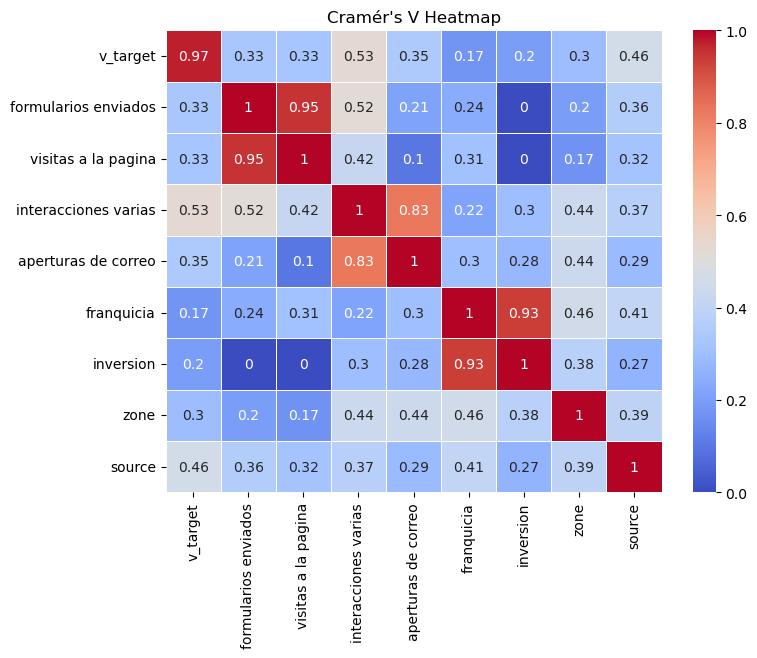

In [25]:
# Cramers_V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
columns_of_interest = ['v_target','formularios enviados', 'visitas a la pagina', 'interacciones varias', 'aperturas de correo', 'franquicia', 'inversion', 'zone', 'source']
df_selected = df[columns_of_interest]
df_sample = df_selected.sample(frac=0.1, random_state=31)
cramers_v_matrix = pd.DataFrame(index=columns_of_interest, columns=columns_of_interest)
for col1 in columns_of_interest:
    for col2 in columns_of_interest:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df_sample[col1], df_sample[col2])
cramers_v_matrix = cramers_v_matrix.astype(float)
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Cramér's V Heatmap")
plt.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">

* It is interesting to note that "interacciones varias" and "fuente_unificada" have a significantly high relationship with the target column.


In [26]:
fig = go.Figure()
zonas_agrupadas = df.groupby(['v_target', 'source']).size().reset_index(name='conteo')
# Obtener los valores únicos de 'v_target'
unique_targets = zonas_agrupadas['v_target'].unique()
# Crear un diccionario de colores que asigna cada valor único a un color
color_dict = {val: colors[i%len(colors)] for i, val in enumerate(unique_targets)}
# Añadir una traza de barras para cada valor único
for elead in unique_targets:
    zonas_elead = zonas_agrupadas[zonas_agrupadas['v_target'] == elead]
    # Asignar el color correcto a la traza
    fig.add_trace(go.Bar(x=zonas_elead['source'], y=zonas_elead['conteo'], name=str(elead), 
                         marker_color=color_dict[elead]))  # Usar el color correspondiente del diccionario
# diseño
fig.update_layout(barmode='stack', title='Relationship between entre Source y Target',
                  xaxis_title='Fuente', yaxis_title='Cantidad de v_target')
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">

* The same in the numerical columns: 

In [27]:
df_avg = df.groupby('v_target')['visitas a la pagina', 'interacciones varias'].mean().reset_index()
fig = px.scatter(df_avg, x="interacciones varias", y="visitas a la pagina",
	         size="interacciones varias", color="v_target",
                 hover_name="v_target", log_x=True, size_max=60)
fig.show()

/tmp/ipykernel_20/3725266836.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [28]:
df_avg = df.groupby('v_target')['visitas a la pagina', 'aperturas de correo'].mean().reset_index()
fig = px.scatter(df_avg, x="visitas a la pagina", y="aperturas de correo",
	         size="aperturas de correo", color="v_target",
                 hover_name="v_target", log_x=True, size_max=60)
fig.show()

/tmp/ipykernel_20/1803415663.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



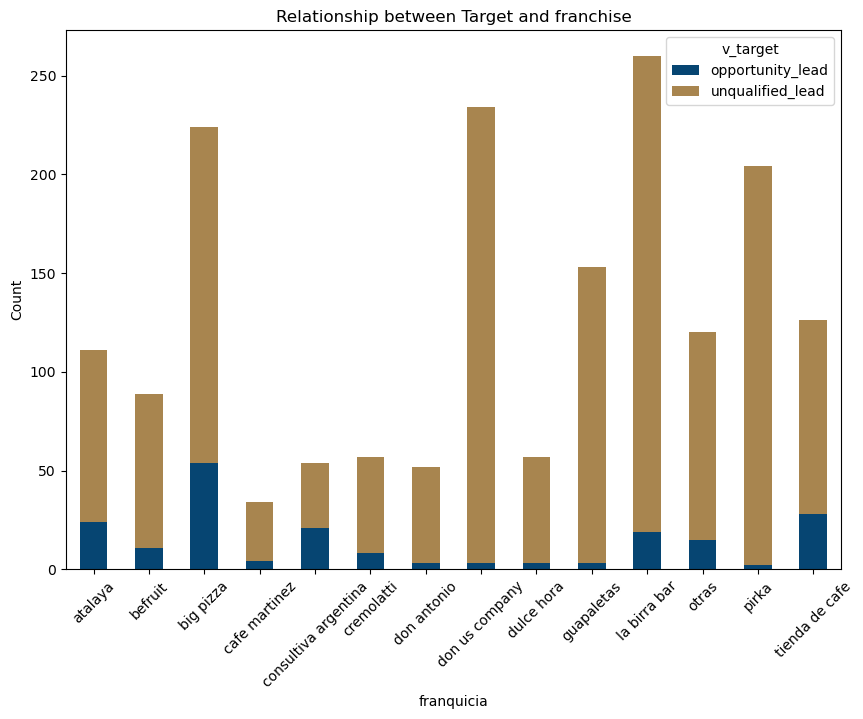

In [29]:
table = pd.crosstab(df['franquicia'], df['v_target'])
# Crear gráfico de barras apilado
table.plot(kind='bar', stacked=True, figsize=(10,7), color=colors)
plt.title('Relationship between Target and franchise')
plt.xlabel('franquicia')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [30]:
fig = go.Figure()
zonas_agrupadas = df.groupby(['v_target', 'zone']).size().reset_index(name='conteo')
# Mapear cada categoría única a un color
unique_targets = zonas_agrupadas['v_target'].unique()
color_dict = {target: colors[i % len(colors)] for i, target in enumerate(unique_targets)}
fig = go.Figure()
for elead in unique_targets:
    zonas_elead = zonas_agrupadas[zonas_agrupadas['v_target'] == elead]
    fig.add_trace(go.Bar(x=zonas_elead['zone'], y=zonas_elead['conteo'], name=str(elead), 
                         marker_color=color_dict[elead]))
# Diseño del gráfico
fig.update_layout(barmode='stack', title='Relationship between Target and  Zone',
                  xaxis_title='Segmento de zone', yaxis_title='Cantidad de leeds')
fig.show()


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🧠 Step 5 Model Definition</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:109%; text-align:left">
    
* I will use a CatBoost model and a Random Forest model due to their ability to handle both categorical and numerical columns. Additionally, I will apply the SMOTE technique to address class imbalances.. 
    
* It is important to note that **90% of the data belongs to the "unqualified_lead"** class, which can bias the model and result in high precision but low effectiveness.. 
    
* **Considering the scarcity of "opportunity_lead" instances, it will be crucial to avoid producing false negatives or misclassifying them as "unqualified_lead" in order to achieve success."**


In [31]:
df.iloc[102:108] 

,v_target,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo,franquicia,inversion,zone,source
282,opportunity_lead,1.0,1.0,2.0,2.0,big pizza,low,buenos aires,referencias
288,unqualified_lead,1.0,1.0,0.0,0.0,don antonio,low,sin valor,redes sociales de pago
291,unqualified_lead,1.0,1.0,3.0,1.0,cafe martinez,high,zonas menos recurrentes,redes sociales de pago
294,unqualified_lead,1.0,1.0,0.0,0.0,pirka,med,sin valor,redes sociales de pago
297,unqualified_lead,1.0,1.0,4.0,1.0,la birra bar,veryhigh,buenos aires,búsqueda de pago
300,unqualified_lead,0.0,0.0,0.0,0.0,guapaletas,med,zonas menos recurrentes,fuentes sin conexión


In [32]:
#Prepro
data = df
X = data.drop("v_target", axis=1)
y = data["v_target"]
numeric_features = ['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_features = ['franquicia', 'inversion', 'zone', 'source']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:107%; text-align:left">

* **Catboost Model**

In [33]:
# CatBoost 
clf1 = make_imb_pipeline(preprocessor, SMOTE(random_state=42), CatBoostClassifier(verbose=0))
params_catboost = {
    'catboostclassifier__iterations': randint(100, 500),
    'catboostclassifier__depth': randint(1, 10),
    'catboostclassifier__learning_rate': uniform(0.01, 0.3),
    'catboostclassifier__l2_leaf_reg': uniform(2, 30)
}
search_catboost = RandomizedSearchCV(clf1, param_distributions=params_catboost, n_iter=10, cv=3, verbose=0, random_state=42, n_jobs=-1)
search_catboost.fit(X_train, y_train)
y_pred_catboost = search_catboost.predict(X_test)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
* 📝 Predictions and metrics


In [34]:
print("Model CatBoost predictions")
print(classification_report(y_test, y_pred_catboost))
hl_c = hamming_loss(y_test, y_pred_catboost)
acc_c = accuracy_score(y_test, y_pred_catboost)
print(f"Hamming Loss:{hl_c}")
print(f"Accuracy: {acc_c}")



Model CatBoost predictions
                  precision    recall  f1-score   support

opportunity_lead       0.70      0.64      0.67        33
unqualified_lead       0.96      0.97      0.97       322

        accuracy                           0.94       355
       macro avg       0.83      0.80      0.82       355
    weighted avg       0.94      0.94      0.94       355

Hamming Loss:0.059154929577464786
Accuracy: 0.9408450704225352


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:107%; text-align:left">

* **RandomForest Model**

In [35]:
# Random Forest
clf2 = make_imb_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())
params_rf = {
    'randomforestclassifier__n_estimators': randint(100, 500),
    'randomforestclassifier__max_depth': randint(1, 50),
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}
search_rf = RandomizedSearchCV(clf2, param_distributions=params_rf, n_iter=10, cv=3, verbose=0, random_state=42, n_jobs=-1)
search_rf.fit(X_train, y_train)
y_pred_rf = search_rf.predict(X_test)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
* 📝Predictions and metrics

In [36]:
# Predicciones y métricas 
print("\nModel RandomForest predictions")
print(classification_report(y_test, y_pred_rf))
hl = hamming_loss(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
print(f"Hamming Loss:{hl}")
print(f"Accuracy: {acc}")


Model RandomForest predictions
                  precision    recall  f1-score   support

opportunity_lead       0.69      0.61      0.65        33
unqualified_lead       0.96      0.97      0.97       322

        accuracy                           0.94       355
       macro avg       0.82      0.79      0.81       355
    weighted avg       0.93      0.94      0.94       355

Hamming Loss:0.061971830985915494
Accuracy: 0.9380281690140845


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📈 Step 6: Training and Validation Models</p>


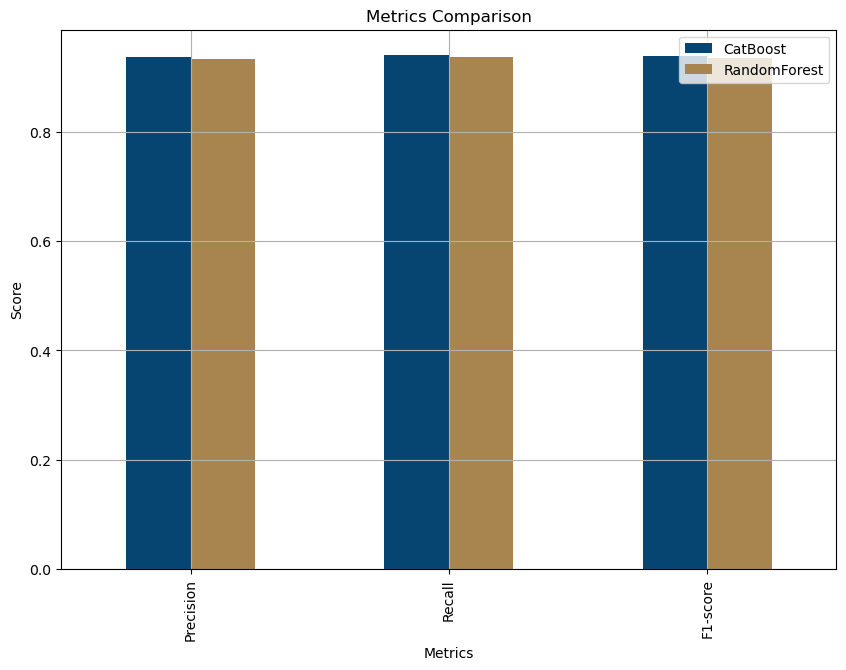

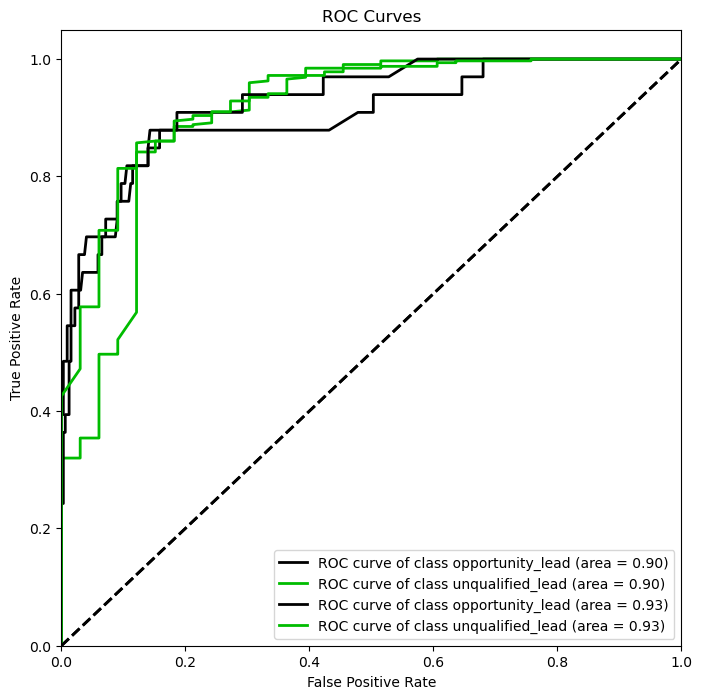

In [37]:

# Precision, recall y F1-score
prec_rec_f1_catboost = precision_recall_fscore_support(y_test, y_pred_catboost, average='weighted')
prec_rec_f1_rf = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')
# Crear df para visualización
df_metrics = pd.DataFrame({
    'Metrics': ['Precision', 'Recall', 'F1-score'],
    'CatBoost': [prec_rec_f1_catboost[0], prec_rec_f1_catboost[1], prec_rec_f1_catboost[2]],
    'RandomForest': [prec_rec_f1_rf[0], prec_rec_f1_rf[1], prec_rec_f1_rf[2]]
})
# Generar gráfico de barras para comparación
df_metrics.plot(x='Metrics', y=['CatBoost', 'RandomForest'], kind='bar', color=colors, figsize=(10, 7))
plt.title('Metrics Comparison')
plt.ylabel('Score')
plt.grid(True)
plt.show()
# Generar la curva ROC
fig, ax = plt.subplots(figsize=(8, 8))
y_probas_catboost = search_catboost.predict_proba(X_test)
y_probas_rf = search_rf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas_catboost, plot_macro=False, plot_micro=False, ax=ax)
skplt.metrics.plot_roc(y_test, y_probas_rf, plot_macro=False, plot_micro=False, ax=ax)
plt.title('ROC Curves')
plt.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">

* As expected, the model exhibits challenges in predicting the minority class "opportunity_lead," which is also the most important class. **Considering the scarcity of opportunities, it will be crucial to avoid producing false negatives or misclassifying them as "unqualified_lead" in order to achieve success.** 

* For this reason, we will set higher probability thresholds for classifying instances as "unqualified_lead." This approach aims to optimize our process and minimize the impact on missed opportunities while maximizing our efficiency and time investment..
    
   

In [38]:
# Adjust and test the new classification threshold
umbral = 0.85

In [39]:
# Para el modelo CatBoost
y_pred_prob_catboost = search_catboost.predict_proba(X_test)[:, 1]
y_pred_adj_catboost = np.where(y_pred_prob_catboost > umbral, "unqualified_lead", "opportunity_lead")

# Para el modelo RandomForest
y_pred_prob_rf = search_rf.predict_proba(X_test)[:, 1]
y_pred_adj_rf = np.where(y_pred_prob_rf > umbral, "unqualified_lead", "opportunity_lead")

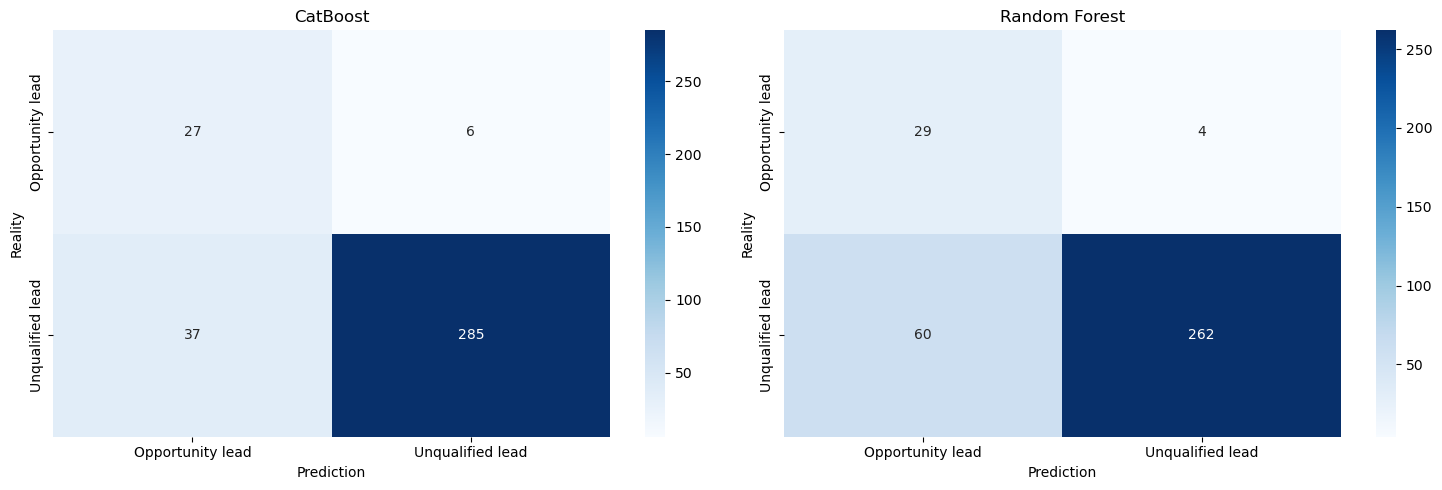

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar las matrices de confusión
cm_catboost = confusion_matrix(y_test, y_pred_adj_catboost)
cm_rf = confusion_matrix(y_test, y_pred_adj_rf)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Usar los nombres de las categorías en lugar de 0 y 1
categories = ['Opportunity lead', 'Unqualified lead']

sns.heatmap(cm_catboost, annot=True, fmt=".0f", ax=axes[0], cmap=plt.cm.Blues, xticklabels=categories, yticklabels=categories)
axes[0].set_title('CatBoost')
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Reality')

sns.heatmap(cm_rf, annot=True, fmt=".0f", ax=axes[1], cmap=plt.cm.Blues, xticklabels=categories, yticklabels=categories)
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Reality')

plt.tight_layout()
plt.show()


In [41]:
print("Updated Classification Report CatBoost; Umbral 83%:")
print(classification_report(y_test, y_pred_adj_catboost))
hl_catboost = hamming_loss(y_test, y_pred_adj_catboost)
acc_catboost = accuracy_score(y_test, y_pred_adj_catboost)
print(f"\nHamming Loss (CatBoost):{hl_catboost}")
print(f"Accuracy (CatBoost): {acc_catboost}\n")

print("\n\nUpdated Classification Report Random Forest; Umbral 83%:")
print(classification_report(y_test, y_pred_adj_rf))
hl_rf = hamming_loss(y_test, y_pred_adj_rf)
acc_rf = accuracy_score(y_test, y_pred_adj_rf)
print(f"\nHamming Loss (Random Forest):{hl_rf}")
print(f"Accuracy (Random Forest): {acc_rf}\n")


Updated Classification Report CatBoost; Umbral 83%:
                  precision    recall  f1-score   support

opportunity_lead       0.42      0.82      0.56        33
unqualified_lead       0.98      0.89      0.93       322

        accuracy                           0.88       355
       macro avg       0.70      0.85      0.74       355
    weighted avg       0.93      0.88      0.90       355


Hamming Loss (CatBoost):0.12112676056338029
Accuracy (CatBoost): 0.8788732394366198



Updated Classification Report Random Forest; Umbral 83%:
                  precision    recall  f1-score   support

opportunity_lead       0.33      0.88      0.48        33
unqualified_lead       0.98      0.81      0.89       322

        accuracy                           0.82       355
       macro avg       0.66      0.85      0.68       355
    weighted avg       0.92      0.82      0.85       355


Hamming Loss (Random Forest):0.18028169014084508
Accuracy (Random Forest): 0.819718309859155



In [42]:
# Para el modelo CatBoost
y_pred_prob_catboost = search_catboost.predict_proba(X_test)
proba_df_catboost = pd.DataFrame(y_pred_prob_catboost, columns=search_catboost.best_estimator_.named_steps['catboostclassifier'].classes_)
proba_df_catboost['Prediccion'] = y_pred_adj_catboost
proba_df_catboost['Resultado?'] = proba_df_catboost['Prediccion'] == y_test.values
print("Brief sample of Odds and Final results (CatBoost):")
print(proba_df_catboost.head(3))
# Para el modelo RandomForest
y_pred_prob_rf = search_rf.predict_proba(X_test)
proba_df_rf = pd.DataFrame(y_pred_prob_rf, columns=search_rf.best_estimator_.named_steps['randomforestclassifier'].classes_)
proba_df_rf['Prediccion'] = y_pred_adj_rf
proba_df_rf['Resultado?'] = proba_df_rf['Prediccion'] == y_test.values
print("\n\nBrief sample of Odds and Final results (Random Forest):")
print(proba_df_rf.head(3))


Brief sample of Odds and Final results (CatBoost):
   opportunity_lead  unqualified_lead        Prediccion  Resultado?
0          0.004453          0.995547  unqualified_lead        True
1          0.075334          0.924666  unqualified_lead       False
2          0.008071          0.991929  unqualified_lead        True


Brief sample of Odds and Final results (Random Forest):
   opportunity_lead  unqualified_lead        Prediccion  Resultado?
0          0.036776          0.963224  unqualified_lead        True
1          0.409545          0.590455  opportunity_lead        True
2          0.056040          0.943960  unqualified_lead        True


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📈 Step 7: Conclusion y resultado</p>



In [43]:
# Obtener verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos de las matrices de confusión
tp_catboost, fn_catboost, fp_catboost, tn_catboost = cm_catboost.ravel()
tp_rf, fn_rf, fp_rf, tn_rf = cm_rf.ravel()
# Crear un DataFrame con estos valores para cada modelo
dfg = pd.DataFrame({
   'Predicted Qualified and turned out to be true (Optimized Attention)': [tp_catboost, tp_rf],
'Predicted a bad lead and it turned out to be true: (Time saving)': [tn_catboost, tn_rf],
'Predicted Qualified and turned out to be false (Waste of time)': [fp_catboost, fp_rf],
'Predicted a bad lead and turned out to be false (Opportunity cost)': [fn_catboost, fn_rf]
}, index=['CatBoost', 'Random Forest'])
# Transponer el DataFrame para que las métricas sean las columnas y los modelos sean las filas
dfg = dfg.T


In [44]:
# Crear un objeto de figura
fig = go.Figure()
# Ejemplo de cómo utilizar los colores en el gráfico de barras apiladas
for i, metric in enumerate(dfg.columns):
    fig.add_trace(go.Bar(
        y=dfg.index,
        x=dfg[metric],
        name=metric,
        marker_color=colors[i % len(colors)],  # Utilizar el color que corresponde a cada modelo
        orientation='h'
    ))
# Agregar título y nombres de ejes
fig.update_layout(
    title_text='Translated into Results',
    xaxis_title='Count',
    yaxis_title='',
    barmode='stack'
)
# Mostrar el gráfico
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:114%; text-align:left">
    
* Finally, by resigning precision we have minimized false "negatives" or false "unqualified_lead", especially with the Random Forest model.

* This model was originally created with a set of 430 leads to optimize my invested time in my role as a consultant. Over time, the introduction of new leads and the use of new techniques have optimized it to this day.

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #217992; font-size:100%; text-align:left">
